# Idea
Do some feature ranking. 

**BUT**: ENTROPY needs addional feature engineering.
**Observations**: X_ROBUST => does not meet Variance => complete entropy becomes useless => removed

| **Possible DataSources** |
| --- |
| SYS_data |
| KERN_data |
| FLS_data |
| RES_data |
| block_data |
| network_data |
| entropy_data |


In [1]:
DATA_SOURCE = "entropy_data"
DEVICE_SOURCE = "Heqing_device2"

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd

In [3]:
import sys
repo_base_path = Path("./../").resolve()
assert str(repo_base_path).endswith("csg_is"), f"{repo_base_path} is not a valid path to the CSG_IS repository" 

sys.path.append(str(repo_base_path))

from py_dataset import get_all_files_df
from py_dataset import read_in_files
from py_dataset import feature_plotting
from py_dataset import feature_selection
from py_dataset import entropy_feature_engineering

In [4]:
data_path = Path('/media/<User>/DC/MAP_CreationOfNewDatasetsForDFL/code&data/0_raw_collected_data/')
assert data_path.exists()

In [5]:
df = get_all_files_df.main(data_path)
df.head(1)

txt file found, will drop /media/<User>/DC/MAP_CreationOfNewDatasetsForDFL/code&data/0_raw_collected_data/Heqing/device1/3_thetick_4h/collections.txt
txt file found, will drop /media/<User>/DC/MAP_CreationOfNewDatasetsForDFL/code&data/0_raw_collected_data/Heqing/device2/1_normal/note.txt
                                           file_path
0  /media/<User>/DC/MAP_CreationOfNewDatasetsForDFL/...
RangeIndex(start=0, stop=622, step=1)
filetype
csv    530
zip     92
Name: count, dtype: int64
                                           file_path filetype  filesize_bytes
0  /media/<User>/DC/MAP_CreationOfNewDatasetsForDFL/...      csv           49419
data_source
SYS_data        92
KERN_data       91
FLS_data        91
RES_data        91
block_data      91
network_data    91
entropy_data    75
Name: count, dtype: int64


,file_path,filetype,filesize_bytes,researcher_name,device_name,label,data_source,file_name,device
0,/media//DC/MAP_CreationOfNewDatasetsForDFL/...,csv,49419,Heqing,device1,1_normal,block_data,e4_5f_01_68_35_e6.csv,Heqing_device1


In [6]:
single_dev_single_data_source = df[(df["device"] == DEVICE_SOURCE) & (df["data_source"] == DATA_SOURCE)]
assert len(single_dev_single_data_source["device"].unique()) == 1 and len(single_dev_single_data_source["data_source"].unique()) == 1
print(single_dev_single_data_source.shape)

(19, 9)


In [7]:
vectors = read_in_files.get_all_columns_from_single_data_source_for_csv_files(single_dev_single_data_source)
vectors.shape

(101606, 4)

#### Entropy Feature Engineering

In [8]:
old_vectors = vectors.copy()
vectors = entropy_feature_engineering.resample_high_entropy_grouping_by_label(vectors, time_window="40s")

#### Preprocessing

In [9]:
vectors.reset_index(inplace=True, drop=True)  # drops: "timestamp"

cols_to_exclude_from_scaling = ["label"]

vectors = feature_plotting.test_transform_all_to_numeric_columns(vectors, cols_to_exclude_from_scaling)
vectors_scaled = feature_plotting.minmax_scale_features(vectors,
                                                        remove_outliers_iqr_all_columns=False,
                                                        cols_to_exclude_from_scaling=cols_to_exclude_from_scaling)

vectors_robust_scaled = feature_plotting.minmax_scale_features(vectors,
                                                               remove_outliers_iqr_all_columns=True,
                                                               cols_to_exclude_from_scaling=cols_to_exclude_from_scaling)

In [10]:
X = vectors_scaled.drop(columns=["label"])
Y = vectors_scaled["label"]

X_ROBUST = vectors_robust_scaled.drop(columns=["label"])

In [11]:
print(X_ROBUST.dropna().shape, X_ROBUST.shape)

X_ROBUST.dropna(inplace=True)
Y_ROBUST = vectors_robust_scaled.dropna()["label"]

(3162, 1) (3438, 1)


#### Ranking

In [12]:
print(feature_selection.get_low_variance_features(X, threshold=0.0))
print(f"{feature_selection.get_low_variance_features(X_ROBUST, threshold=0.0)}: Will be removed if outliers are removed")

[]


ValueError: No feature in X meets the variance threshold 0.00000

In [13]:
X.drop(columns=feature_selection.get_low_variance_features(X, threshold=0.0), inplace=True)

In [14]:
scores_by_label = feature_selection.calculate_scores_by_label(X, Y)
scores_by_label.groupby("feature")[[ "chi2", "f_classif", "mutual_info_classif"]].mean()
singles = scores_by_label.groupby("feature")[[ "chi2", "f_classif", "mutual_info_classif"]].mean()

Label: 1_normal
Label: 2_ransomware
Label: 3_thetick
Label: 4_bashlite
Label: 5_httpbackdoor
Label: 6_beurk
Label: 7_backdoor
Label: 8_bdvl
Label: 9_xmrig


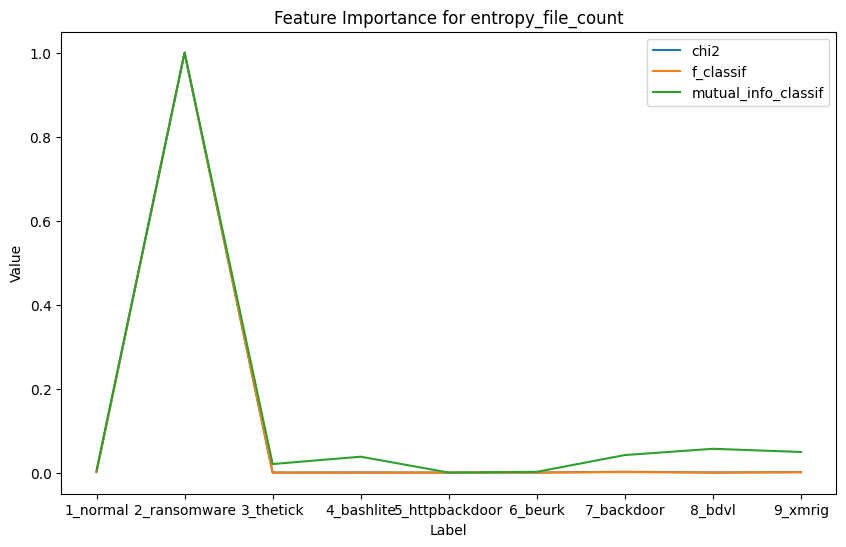

In [15]:
test_df = scores_by_label.copy()
feature_selection.sort_by_mean(test_df)
test_df.reset_index(inplace=True)
best_Feature = test_df.loc[0]["feature"]

feature_selection.plot_scores_by_label_single_plot_single_feature( scores_by_label, best_Feature)

In [16]:
# scores = feature_selection.calculate_scores(X, Y)
# feature_selection.plot_single_scores(scores)

# singles = singles.loc[scores["feature"].unique()]
# singles = singles.reset_index()
# feature_selection.plot_single_scores(singles)

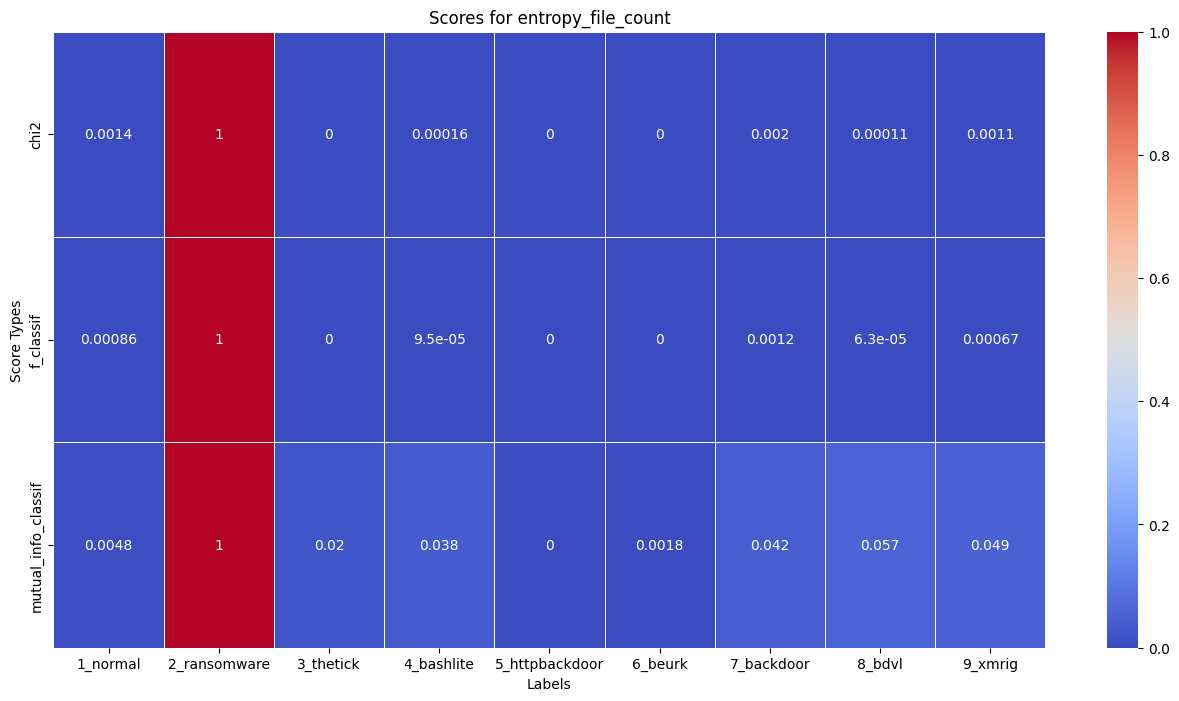

In [17]:
feature_selection.heatmap_for_single_feature_by_label(scores_by_label, scores_by_label["feature"].iloc[0])

In [34]:
# feature_selection.heatmap_scores_by_label_versus_features(scores_by_label)

#### Storing scores

In [18]:
output_dir = repo_base_path / "feature_selection" / "result"
output_file_X = output_dir / f"{DATA_SOURCE}_{DEVICE_SOURCE}_featurescores.csv"

In [19]:
scores_by_label.to_csv(output_file_X, index=False)